## Setup

Requirements: Install the jaxopt package.

In [12]:
%env CUDA_VISIBLE_DEVICES=0

import jax
from jax import numpy as jnp
from jax import nn
import numpy as np
from flax import linen as nn
from flax.linen import initializers as nni
from flax.traverse_util import flatten_dict, unflatten_dict
from jax import random as jr
from util import *
import optax
import pickle
import argparse
from matplotlib import cm

from model import Transformer
from tasks import Task, ModPSeq2SeqTask

env: CUDA_VISIBLE_DEVICES=0


## SimpleTask

In [2]:
# L = Lipschitz constant
# seed = random seed
# The following function trains single layer transformers on SimpleTask. Models are trained with max training length selected from train_lengths, 
#   and tested on sequences of lengths in test_lengths.
def run(L, seed):
    
    rng = RNG(seed)
    vocab_size = 3
    problem = Task(vocab_size, 0, 1)
    
    max_length = 80

    d_model = 16
    heads = 1
    width = 256
    
    # initialize model
    model = Transformer(vocab_size, max_length, 1, d_model, heads, width, 0, False)
    p0 = model.init(rng.next(), vmap(lambda key: problem.sample(max_length, key, 1))(rng.next(2))[0])
    p0 = flatten_dict(p0["params"], sep=".")

    criterion = lambda f, y: (y - f)**2

    @partial(jit, static_argnames="mutable")
    def f(p, *args, **kwargs):
        p = dict(params=unflatten_dict(p, sep="."))
        return model.apply(p, *args, **kwargs)
        
    @jit
    def loss_fn(p, batch):
        x, y = batch
        # only compute prediction on second token onwards
        return vmap(criterion)(f(p, x)[:,1:], y).mean()

    @jit
    def test_loss_fn(p, batch):
        x, y = batch
        # only compute prediction on last token
        return vmap(criterion)(f(p, x)[:,-1], y[:,-1]).mean()

    models = []

    # maximum training lengths
    train_lengths = [i for i in jnp.arange(4, 21)]
    
    train_losses = []

    # loop over train_lengths
    for train_length in train_lengths:

        p = p0
        lr = 3e-3
        steps = 2**13
        save_every = steps // 128
        batch_size = 2**10
        max_size = 2**20 # 2**24
        epoch_len = max_size // batch_size
        sample_fn = lambda k: vmap(lambda key: problem.sample(train_length, key, L))(jr.split(k, epoch_len * batch_size))

        def batch_iterator(key):
            while True:
                key, subkey = jr.split(key)
                batches = sample_fn(subkey)
                for i in range(epoch_len):
                    yield tree_map(lambda x: x[batch_size * i : batch_size * (i + 1)], batches)
                    
        iterator = batch_iterator(rng.next())
                    
        # muP scaling for Adam
        opt = optax.multi_transform(
        {
            'embed': optax.adam(learning_rate = lr),
            'hidden': optax.adam(learning_rate = lr/d_model)
        },
        {
            'wte':'embed',
            'unembed':'embed',
            'Q':'hidden',
            'K':'hidden',
            'V':'hidden',
            'O':'hidden',
            'layer1.kernel': 'hidden',
            'layer1.bias': 'hidden',
            'layer2.kernel': 'hidden'
        })

        @jit
        def step_fn(p, batch, opt_state):
            loss, g = jax.value_and_grad(loss_fn)(p, batch)
            updates, opt_state = opt.update(g, opt_state, p)
            p = optax.apply_updates(p, updates)
            return p, opt_state, loss


        train_loss = []
        test_loss = []

        opt_state = opt.init(p0)
        for i in trange(steps):
            batch = next(iterator)
            loss = loss_fn(p, batch)
            if loss < 1e-5 or jnp.isinf(loss):
                break
            p, opt_state, loss = step_fn(p, batch, opt_state)
            train_loss.append(loss)
        
        print("final loss = ", loss)
        train_losses.append(loss)
        models.append(p)
        
    # evaluate models on test_lengths
    
    test_samples = 2**10
    test_rng = rng.next()
    test_lengths = [i for i in jnp.arange(4, 81, 4)]
    all_losses = []
    for test_length in test_lengths:
        test_losses = []
        testx, testy = vmap(lambda key: problem.sample(test_length, key, L))(jr.split(test_rng, test_samples))
        for p in models:
            test_loss = test_loss_fn(p, (testx, testy))
            test_losses.append(test_loss)
        all_losses.append(test_losses)
        
    all_losses = np.array(all_losses)
        
    return all_losses, models

In [ ]:
# number of random seeds to consider. each trial takes ~30 minutes
num_trials = 5
seeds = [i for i in jnp.arange(0, num_trials)]

# Lipschitz constants to consider
Ls = [i for i in jnp.arange(2, 6, 0.5)]


# loop over all Lipschitz constants L and seeds
all_results = []
for L in Ls:
    results = []
    for seed in seeds:
        res, _ = run(L, seed)
        results.append(res)
    results = np.array(results)
    results = np.mean(results, axis=0)
    all_results.append(results)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times, Palatino, New Century Schoolbook, Bookman, Computer Modern Roman
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times, Palatino, New Century Schoolbook, Bookman, Computer Modern Roman


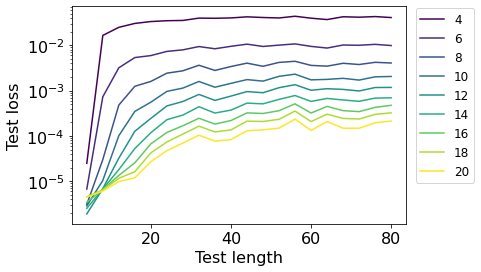

In [4]:
# plot test loss as a function of test length, for varying train lengths.
results = all_results[1]
train_lengths = np.arange(4, 21)
test_lengths = np.arange(4, 81, 4)

gradient = np.linspace(0, 1, results.shape[1])
colors = cm.viridis(gradient)

plt.style.use('style.mplstyle')
for i in np.arange(0, results.shape[1], 2):
    plt.plot(test_lengths, [result[i] for result in results], label = train_lengths[i], color = colors[i])
plt.xlabel("Test length")
plt.ylabel("Test loss")
plt.yscale("log")
plt.legend(bbox_to_anchor=(1.22, 1.02), loc="upper right", fontsize = 12)
plt.show()

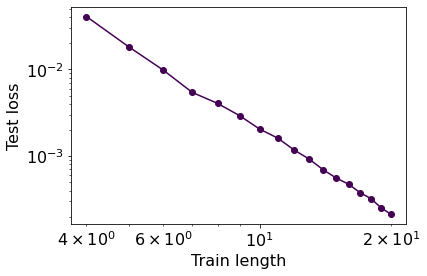

In [5]:
# plot limiting test loss as a function of train length.
plt.plot(train_lengths, results[-1], marker = 'o', color = colors[0])
plt.ylabel("Test loss")
plt.xlabel("Train length")
plt.yscale("log")
plt.xscale("log")

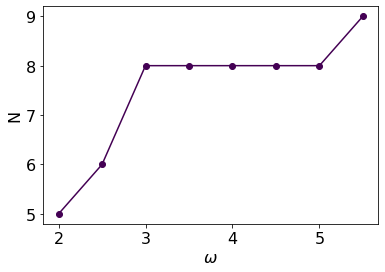

In [6]:
# plot minimum train length needed to obtain loss <= epsilon
epsilon = 1e-2
Ns = []
for i in range(len(Ls)):
    Ns.append(train_lengths[jnp.argmax(all_results[i][-1, :] < epsilon)])
plt.plot(Ls, Ns, color = colors[0], marker = 'o')
plt.xlabel(r'$\omega$')
plt.ylabel("N")
plt.show()

## Mod P Task

In [ ]:
# delta = periodicity parameter in ModPTask
def run(delta, seed):
    rng = RNG(seed)
    
    problem = ModPSeq2SeqTask(delta, 1) # attend to position == 1 mod k.
    vocab_size = 2

    max_length = 40*delta

    d_model = 16
    heads = 1
    width = 256

    # init model
    model = Transformer(vocab_size, max_length, 1, d_model, heads, width, delta, True)
    p0 = model.init(rng.next(), vmap(lambda key: problem.sample(max_length, key))(rng.next(2))[0])
    p0 = flatten_dict(p0["params"], sep=".")

    criterion = lambda f, y: (y - f)**2

    @partial(jit, static_argnames="mutable")
    def f(p, *args, **kwargs):
        p = dict(params=unflatten_dict(p, sep="."))
        return model.apply(p, *args, **kwargs)
        
    @jit
    def loss_fn(p, batch):
        x, y = batch
        # only compute prediction on delta onwards
        return vmap(criterion)(f(p, x)[:,delta-1:], y).mean()

    @jit
    def test_loss_fn(p, batch):
        x, y = batch
        # only compute prediction on last token
        return vmap(criterion)(f(p, x)[:,-1], y[:,-1]).mean()

    models = []

    train_lengths = [i for i in jnp.arange(delta, 5*delta+1, delta)]
    
    train_losses = []

    for train_length in train_lengths:

        p = p0
        lr = 3e-3
        steps = 2**13
        save_every = steps // 128
        batch_size = 2**10
        max_size = 2**20 # 2**24
        epoch_len = max_size // batch_size
        sample_fn = lambda k: vmap(lambda key: problem.sample(train_length, key))(jr.split(k, epoch_len * batch_size))

        def batch_iterator(key):
            while True:
                key, subkey = jr.split(key)
                batches = sample_fn(subkey)
                for i in range(epoch_len):
                    yield tree_map(lambda x: x[batch_size * i : batch_size * (i + 1)], batches)
                    
        iterator = batch_iterator(rng.next())
                    
        # muP scaling
        opt = optax.multi_transform(
        {
            'embed': optax.adam(learning_rate = lr),
            'hidden': optax.adam(learning_rate = lr/d_model)
        },
        {
            'wte':'embed',
            'PeriodicPositionalEncoding_0.wpe': 'embed',
            'unembed':'embed',
            'Q':'hidden',
            'K':'hidden',
            'V':'hidden',
            'O':'hidden',
            'layer1.kernel': 'hidden',
            'layer1.bias': 'hidden',
            'layer2.kernel': 'hidden'
        })

        @jit
        def step_fn(p, batch, opt_state):
            loss, g = jax.value_and_grad(loss_fn)(p, batch)
            updates, opt_state = opt.update(g, opt_state, p)
            p = optax.apply_updates(p, updates)
            return p, opt_state, loss


        train_loss = []
        test_loss = []

        opt_state = opt.init(p0)
        for i in trange(steps):
            batch = next(iterator)
            loss = loss_fn(p, batch)
            if loss < 1e-5 or jnp.isinf(loss):
                break
            p, opt_state, loss = step_fn(p, batch, opt_state)
            train_loss.append(loss)
        print("final loss = ", loss)
        train_losses.append(loss)
        models.append(p)
        
    # evaluate on test lengths
    
    test_samples = 2**10
    test_rng = rng.next()

    test_lengths = [i for i in jnp.arange(delta, 20*delta + 1, delta)]
    all_losses = []
    for test_length in test_lengths:
        test_losses = []
        testx, testy = vmap(lambda key: problem.sample(test_length, key))(jr.split(test_rng, test_samples))
        for p in models:
            test_loss = test_loss_fn(p, (testx, testy))
            test_losses.append(test_loss)
        all_losses.append(test_losses)
        
    all_losses = np.array(all_losses)
        
    return all_losses, models

In [ ]:
# number of random seeds to consider. each trial takes ~10 minutes
num_trials = 5
seeds = [i for i in jnp.arange(num_trials)]

# periodicity parameters delta
deltas = [i for i in range(3, 9)]


# loop over delta and seed
all_results = []
for delta in deltas:
    results = []
    for seed in seeds:
        res, _ = run(delta, seed)
        results.append(res)
    results = np.array(results)
    results = np.mean(results, axis=0)
    all_results.append(results)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times, Palatino, New Century Schoolbook, Bookman, Computer Modern Roman
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times, Palatino, New Century Schoolbook, Bookman, Computer Modern Roman


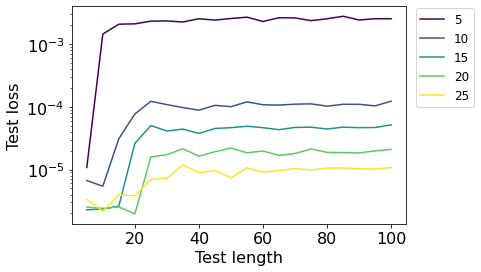

In [4]:
# plot test loss as a function of test length, for varying train lengths.
results = all_results[-1]
train_lengths = np.arange(5, 26, 5)
test_lengths = np.arange(5, 101, 5)

gradient = np.linspace(0, 1, results.shape[1])
colors = cm.viridis(gradient)

plt.style.use('style.mplstyle')
for i in np.arange(0, results.shape[1]):
    plt.plot(test_lengths, [result[i] for result in results], label = train_lengths[i], color = colors[i])
plt.xlabel("Test length")
plt.ylabel("Test loss")
plt.yscale("log")
plt.legend(bbox_to_anchor=(1.22, 1.02), loc="upper right", fontsize = 12)
plt.show()

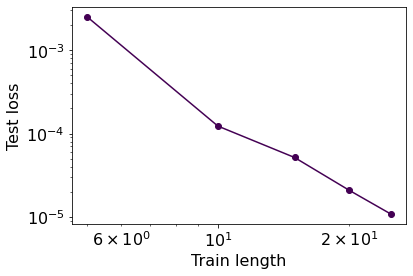

In [5]:
# plot limiting test loss as a function of train length
plt.plot(train_lengths, results[-1], marker = 'o', color = colors[0])
plt.ylabel("Test loss")
plt.xlabel("Train length")
plt.yscale("log")
plt.xscale("log")

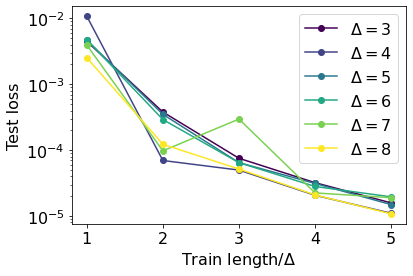

In [6]:
# plot limiting test loss as delta varies.
gradient = np.linspace(0, 1, len(all_results))
colors = cm.viridis(gradient)

for i in range(len(all_results)):
    plt.plot(np.arange(1, 6), all_results[i][-1, :], color = colors[i], marker = 'o', label = r'$\Delta = $' + str(deltas[i]))
plt.yscale("log")
plt.xlabel("Train length/" + r'$\Delta$')
plt.ylabel("Test loss")
plt.legend()
plt.show()

## Plot Attention Probabilities

In [7]:
# generate test samples
rng = RNG(0)
test_samples = 1024
test_length = 80
problem = ModPSeq2SeqTask(5, 1)
testx, testy = vmap(lambda key: problem.sample(test_length, key))(jr.split(rng.next(), test_samples))

# initialize empty model
max_length = 80
delta = 5
model = Transformer(2, max_length, 1, 16, 1, 256, delta, True)
p0 = model.init(rng.next(), vmap(lambda key: problem.sample(80, key))(rng.next(2))[0])
p0 = flatten_dict(p0["params"], sep=".")

(2, 80, 1, 16)
(2, 80, 16)


In [ ]:
_, models = run(delta, 0)

In [9]:
# x = input sequence
# p = model
# output attention probabilities on the sequence x (length T sequence)
def compute_attn_logits(x, p):  
    T = testx.shape[-1]
    x = model.embed(x, p['wte'])
    repeat_count = (max_length + delta - 1) // delta
    wpe_big = jnp.tile(p['PeriodicPositionalEncoding_0.wpe'], (repeat_count, 1))
    x = x + wpe_big[:T]
    
    attn = jnp.einsum("...ij,jm,km,...lk -> ...il", x, p['Q'][0], p['K'][0], x)
        
    attn = attn/model.d
    attn = jnp.where(jnp.tri(T), attn, -jnp.inf)
    attn = nn.softmax(attn)

    return attn

In [10]:
# mean and std of k mod p tokens
yes_mean = []
yes_std = []

# mean and std of remaining tokens
no_mean = []
no_std = []

# compute average attention for each model
for p in models:
    attn = compute_attn_logits(testx, p)
    
    last_attn = attn[:, -1, :]
    last_attn = last_attn.reshape(-1)
    last_attn = last_attn.reshape(-1, 5)
    
    yes_mean.append(last_attn.mean(axis=0)[1])
    yes_std.append(last_attn.std(axis=0)[1])
    
    no_mean.append(last_attn[:, [0, 2, 3, 4]].mean())
    no_std.append(last_attn[:, [0, 2, 3, 4]].std())
yes_mean = np.array(yes_mean)
yes_std = np.array(yes_std)
no_mean = np.array(no_mean)
no_std = np.array(no_std)

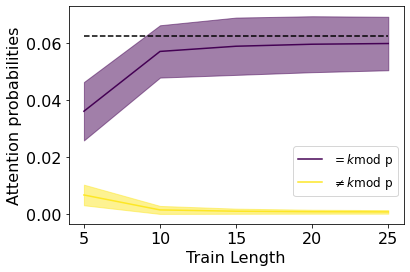

In [11]:
# Generate plot
gradient = np.linspace(0, 1, 2)
colors = cm.viridis(gradient)


plt.style.use('style.mplstyle')

plt.plot(np.arange(5, 26, 5), yes_mean, label = r'$= k$' + 'mod p', color = colors[0])
plt.fill_between(np.arange(5, 26, 5), yes_mean - yes_std, yes_mean+yes_std, color = colors[0], alpha = 0.5)

plt.plot(np.arange(5, 26, 5), no_mean, label = r'$\neq k$' + 'mod p', color = colors[1])
plt.fill_between(np.arange(5, 26, 5), no_mean - no_std, no_mean+no_std, color = colors[1], alpha = 0.5)

plt.plot([5, 25], [1./16, 1./16], linestyle = 'dashed', color = 'black')

plt.xlabel("Train Length")
plt.ylabel("Attention probabilities")

plt.legend(loc="lower right", bbox_to_anchor=(1.0, 0.1), fontsize = 12)
plt.show()